In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from sklearn import preprocessing
from sklearn.covariance import OAS, EmpiricalCovariance, EllipticEnvelope, GraphicalLassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import Nystroem


plt.style.use("seaborn-v0_8")

In [2]:
random_state = 42

df = pd.read_csv("train.csv")

df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]

test_size = 0.3

# "stratify" is set because the target is very imbalanced
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, stratify=df_y, random_state=random_state)
print("Train: {}\nTest: {}".format(X_train.shape, X_test.shape))

print("\n======== TRAIN: labels count")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Year {u}: {c}")

Train: (176522, 90)
Test: (75653, 90)

======== TRAIN: labels count
Year 1956: 198
Year 1957: 209
Year 1958: 204
Year 1959: 207
Year 1960: 148
Year 1961: 200
Year 1962: 211
Year 1963: 316
Year 1964: 331
Year 1965: 392
Year 1966: 482
Year 1967: 601
Year 1968: 654
Year 1969: 774
Year 1970: 822
Year 1971: 746
Year 1972: 801
Year 1973: 909
Year 1974: 764
Year 1975: 869
Year 1976: 762
Year 1977: 876
Year 1978: 1024
Year 1979: 1088
Year 1980: 1086
Year 1981: 1107
Year 1982: 1259
Year 1983: 1185
Year 1984: 1179
Year 1985: 1252
Year 1986: 1477
Year 1987: 1793
Year 1988: 1963
Year 1989: 2334
Year 1990: 2540
Year 1991: 3026
Year 1992: 3340
Year 1993: 3684
Year 1994: 4243
Year 1995: 4640
Year 1996: 4945
Year 1997: 5314
Year 1998: 5535
Year 1999: 6383
Year 2000: 6749
Year 2001: 7556
Year 2002: 8208
Year 2003: 9584
Year 2004: 10362
Year 2005: 12233
Year 2006: 13137
Year 2007: 13791
Year 2008: 12166
Year 2009: 10863


First version of undersampling than oversampling

In [3]:
# count number of samples per label (for each row: index is the label, value is the count)
counts = np.bincount(y_train)

X_resampled, y_resampled = X_train, y_train

# undersampling
total_samples = 50000  # total samples wanted after undersampling
# number of samples per class to respect the total_samples limit
samples_per_class = total_samples // len(np.unique(y_train))
sampling_strategy_under = {
    class_label: min(samples_per_class, counts[class_label]) for class_label in np.unique(y_train)
}
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=random_state)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)


# oversampling
# find the maximum count across all classes
max_count = np.max(np.bincount(y_resampled))
# oversampling and undersampling strategies
sampling_strategy_over = {
    class_label: max_count for class_label in np.unique(y_train) if counts[class_label] < max_count
}
over = BorderlineSMOTE(sampling_strategy=sampling_strategy_over, k_neighbors=20, random_state=random_state)
X_resampled, y_resampled = over.fit_resample(X_resampled, y_resampled)


# add to test set the removed samples
mask = np.isin(X_train, X_resampled).all(axis=1)
X_removed = X_train[~mask]
y_removed = y_train[~mask]
X_test = pd.DataFrame(np.concatenate((X_test, X_removed)))
y_test = np.concatenate((y_test, y_removed))

X_train = pd.DataFrame(X_resampled)
y_train = y_resampled

print("RESAMPLED Train: {}\nRESAMPLED Test: {}".format(X_train.shape, X_test.shape))
print("\n======== RESAMPLED TRAIN: labels count")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Year {u}: {c}")

RESAMPLED Train: (49950, 90)
RESAMPLED Test: (211096, 90)

======== RESAMPLED TRAIN: labels count
Year 1956: 925
Year 1957: 925
Year 1958: 925
Year 1959: 925
Year 1960: 925
Year 1961: 925
Year 1962: 925
Year 1963: 925
Year 1964: 925
Year 1965: 925
Year 1966: 925
Year 1967: 925
Year 1968: 925
Year 1969: 925
Year 1970: 925
Year 1971: 925
Year 1972: 925
Year 1973: 925
Year 1974: 925
Year 1975: 925
Year 1976: 925
Year 1977: 925
Year 1978: 925
Year 1979: 925
Year 1980: 925
Year 1981: 925
Year 1982: 925
Year 1983: 925
Year 1984: 925
Year 1985: 925
Year 1986: 925
Year 1987: 925
Year 1988: 925
Year 1989: 925
Year 1990: 925
Year 1991: 925
Year 1992: 925
Year 1993: 925
Year 1994: 925
Year 1995: 925
Year 1996: 925
Year 1997: 925
Year 1998: 925
Year 1999: 925
Year 2000: 925
Year 2001: 925
Year 2002: 925
Year 2003: 925
Year 2004: 925
Year 2005: 925
Year 2006: 925
Year 2007: 925
Year 2008: 925
Year 2009: 925


Second version: undersampling or oversampling

In [4]:
total_samples = 10000  # total samples wanted after undersampling

# count number of samples per label (for each row: index is the label, value is the count)
counts = np.bincount(y_train)
# number of samples per class to respect the total_samples limit
samples_per_class = total_samples // len(np.unique(y_train))
# find the maximum count across all classes
max_count = np.max(counts)

# oversampling and undersampling strategies
sampling_strategy_over = {
    class_label: max_count for class_label in np.unique(y_train) if counts[class_label] < max_count
}

# sampling_strategy_under = {
#     class_label: min(samples_per_class, counts[class_label]) for class_label in np.unique(y_train)
# }

X_resampled, y_resampled = X_train, y_train

# oversampling
over = BorderlineSMOTE(sampling_strategy=sampling_strategy_over, k_neighbors=20, random_state=random_state)
X_resampled, y_resampled = over.fit_resample(X_resampled, y_resampled)

# undersampling
# under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=random_state)
# X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# add to test set the removed samples
mask = np.isin(X_train, X_resampled).all(axis=1)
X_removed = X_train[~mask]
y_removed = y_train[~mask]
X_test = pd.DataFrame(np.concatenate((X_test, X_removed)))
y_test = np.concatenate((y_test, y_removed))

X_train = pd.DataFrame(X_resampled)
y_train = y_resampled

print("RESAMPLED Train: {}\nRESAMPLED Test: {}".format(X_train.shape, X_test.shape))
print("\n======== RESAMPLED TRAIN: labels count")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Year {u}: {c}")

RESAMPLED Train: (744714, 90)
RESAMPLED Test: (75653, 90)

======== RESAMPLED TRAIN: labels count
Year 1956: 13791
Year 1957: 13791
Year 1958: 13791
Year 1959: 13791
Year 1960: 13791
Year 1961: 13791
Year 1962: 13791
Year 1963: 13791
Year 1964: 13791
Year 1965: 13791
Year 1966: 13791
Year 1967: 13791
Year 1968: 13791
Year 1969: 13791
Year 1970: 13791
Year 1971: 13791
Year 1972: 13791
Year 1973: 13791
Year 1974: 13791
Year 1975: 13791
Year 1976: 13791
Year 1977: 13791
Year 1978: 13791
Year 1979: 13791
Year 1980: 13791
Year 1981: 13791
Year 1982: 13791
Year 1983: 13791
Year 1984: 13791
Year 1985: 13791
Year 1986: 13791
Year 1987: 13791
Year 1988: 13791
Year 1989: 13791
Year 1990: 13791
Year 1991: 13791
Year 1992: 13791
Year 1993: 13791
Year 1994: 13791
Year 1995: 13791
Year 1996: 13791
Year 1997: 13791
Year 1998: 13791
Year 1999: 13791
Year 2000: 13791
Year 2001: 13791
Year 2002: 13791
Year 2003: 13791
Year 2004: 13791
Year 2005: 13791
Year 2006: 13791
Year 2007: 13791
Year 2008: 13791
Y

---
# Preprocessing

- [Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation) is tested
- [Shrinkage, Oracle Approximating Shrinkage (OAS)](https://en.wikipedia.org/wiki/Shrinkage_(statistics)#:~:text=In%20statistics%2C%20shrinkage%20is%20the,coefficient%20of%20determination%20'shrinks') is tested because requires normal distributed data
- [Empirical covariance](https://scikit-learn.org/stable/modules/covariance.html#empirical-covariance) is tested because requires normal distributed data
- [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) is tested because it's robust to anomalies, requires normal and unimodal distributed data
- LDA with eigenvalues solver for dimensionality reduction

In [5]:
# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers_list = [
    # ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    # ("std-scaled", [("std-scaler", preprocessing.StandardScaler())], {}),
    # ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),
    # (
    #     "min-max + lmax + pca 0.95",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lmax", preprocessing.Normalizer(norm="max")),
    #         ("pca", PCA(random_state=random_state)),
    #     ],
    #     {
    #         "pca__svd_solver": ["full"],
    #         "pca__n_components": [0.95],
    #         "pca__whiten": [True, False],
    #     },
    # ),
    # (
    #     "min-max + lda2",
    #     [("min-max", preprocessing.MinMaxScaler()), ("lda", LinearDiscriminantAnalysis())],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             # EllipticEnvelope(random_state=random_state, contamination=0.001),
    #             # EmpiricalCovariance(),
    #             # GraphicalLassoCV(cv=3), # too much computational expensive
    #             OAS(),
    #             # None,
    #         ],
    #     },
    # ),
    # (
    #     "min-max + lmax + lda2",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lmax", preprocessing.Normalizer(norm="max")),
    #         ("lda", LinearDiscriminantAnalysis()),
    #     ],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             # EllipticEnvelope(random_state=random_state, contamination=0.001),
    #             # EmpiricalCovariance(),
    #             # GraphicalLassoCV(cv=3), # too much computational expensive
    #             OAS(),
    #             # None,
    #         ],
    #     },
    # ),
    (
        "min-max + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
]

---
---
# Modeling
- For every preprocess method defined above, execute a GridSearch over the preprocess parameters plus the model parameters
- Then it's chosen the best model with the best preprocess method looking at the R^2 score
- "StratifiedKFold" is chosen to keep the proportion of imbalanced target lables

In [8]:
def gridSearch(name_estimator, estimator, param_estimator, cv):
    searches = {}
    predictions = {}
    for name_step, transformers, param_grid in transformers_list:
        pipe = Pipeline([*transformers, (name_estimator, estimator)])
        gs = GridSearchCV(
            pipe,
            param_grid={**param_estimator, **param_grid},
            # n_jobs=-1,
            cv=cv,
            verbose=3,
            # pre_dispatch=8,
        )

        gs.fit(X_train.values, y_train)

        y_pred = gs.best_estimator_.predict(X_test.values)

        searches[name_step] = gs
        predictions[name_step] = y_pred

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)
            )
        )
    return searches, predictions

In [9]:
def print_store_results(searches: dict, predictions: dict, name_est):
    best_r2_score = -100
    best_preprocessor = []
    best_estimator = None
    best_search_name = None

    for name_step, gs in searches.items():
        r2 = r2_score(y_test, predictions[name_step])

        if r2 > best_r2_score:
            best_r2_score = r2
            best_search_name = name_step
            best_preprocessor = gs.best_estimator_[:-1]  # take all but estimator
            best_estimator = gs.best_estimator_[-1]

        print(
            "----> {} data. Params: {}. R^2: {}. MSE: {}".format(
                name_step, gs.best_params_, r2, mean_squared_error(y_test, predictions[name_step])
            )
        )

        if name_step in [
            "min-max + pca",
            "min-max + pca 0.95",
            "min-max + std-scaler + pca 0.95",
            "min-max + lmax + pca 0.95",
            "min-max + lda1",
            "min-max + lda2",
            "min-max + lda3",
            "std-scaler + lda2",
            "min-max + lmax + lda2",
        ]:
            ratio = gs.best_estimator_[-2].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["lda1", "lda2", "lda3"]:
            ratio = gs.best_estimator_[0].explained_variance_ratio_
            print(
                "\t\t{}: number of components={}, total variance={}".format(
                    name_step, len(ratio), np.flip(ratio.cumsum())[0]
                )
            )
        if name_step in ["min-max + ica"]:
            print("\t\t{}: number of components={}".format(name_step, len(gs.best_estimator_[1].components_)))

    file = open(name_est + "_preproc_" + ".save", "wb")
    pickle.dump(best_preprocessor, file)
    file = open(name_est + "_model_" + ".save", "wb")
    pickle.dump(best_estimator, file)
    file.close()

    print("\nSAVED: ----> {} data. R^2: {}".format(best_search_name, best_r2_score))

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.grid(None)
    fig.tight_layout()
    cmp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        np.round(predictions[best_search_name]).astype(int),
        ax=ax,
        xticks_rotation=80,
        include_values=False,
        cmap="gist_stern",  # "magma",
        colorbar=False,
    )
    ax.plot(range(len(cmp.confusion_matrix)), range(len(cmp.confusion_matrix)), color="white", linestyle="dotted")
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(cmp.im_, cax=cax)
    plt.show()

---
## Linear Regression
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- LDA is a bit better than PCA but with fewer components (53)
- The result R^2=0.237, MSE=83.99, are given with all the following:
    - Raw data
    - Standard-scaled data
    - Min-max + LDA with EmpiricalCovariance as covariance estimators and "eigen" solver
    - Min-max + LDA with "svd" solver and store_covariance=True
- The best results are R^2=0.242,  MSE=83.47 with Min-max + l-max-Normalization + LDA with EmpiricalCovariance

In [92]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {}

searches, predictions = gridSearch("lr", LinearRegression(), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END lda__covariance_estimator=OAS(), lda__shrinkage=None, lda__solver=eigen;, score=0.351 total time=   0.4s
[CV 1/3] END lda__covariance_estimator=OAS(), lda__shrinkage=None, lda__solver=eigen;, score=0.326 total time=   0.4s
[CV 3/3] END lda__covariance_estimator=OAS(), lda__shrinkage=None, lda__solver=eigen;, score=0.364 total time=   0.4s
----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: -2.623360805756387. MSE: 235.4763870530448


----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: -2.623360805756387. MSE: 235.4763870530448
		min-max + lmax + lda2: number of components=53, total variance=1.2747311201220386

SAVED: ----> min-max + lmax + lda2 data. R^2: -2.623360805756387


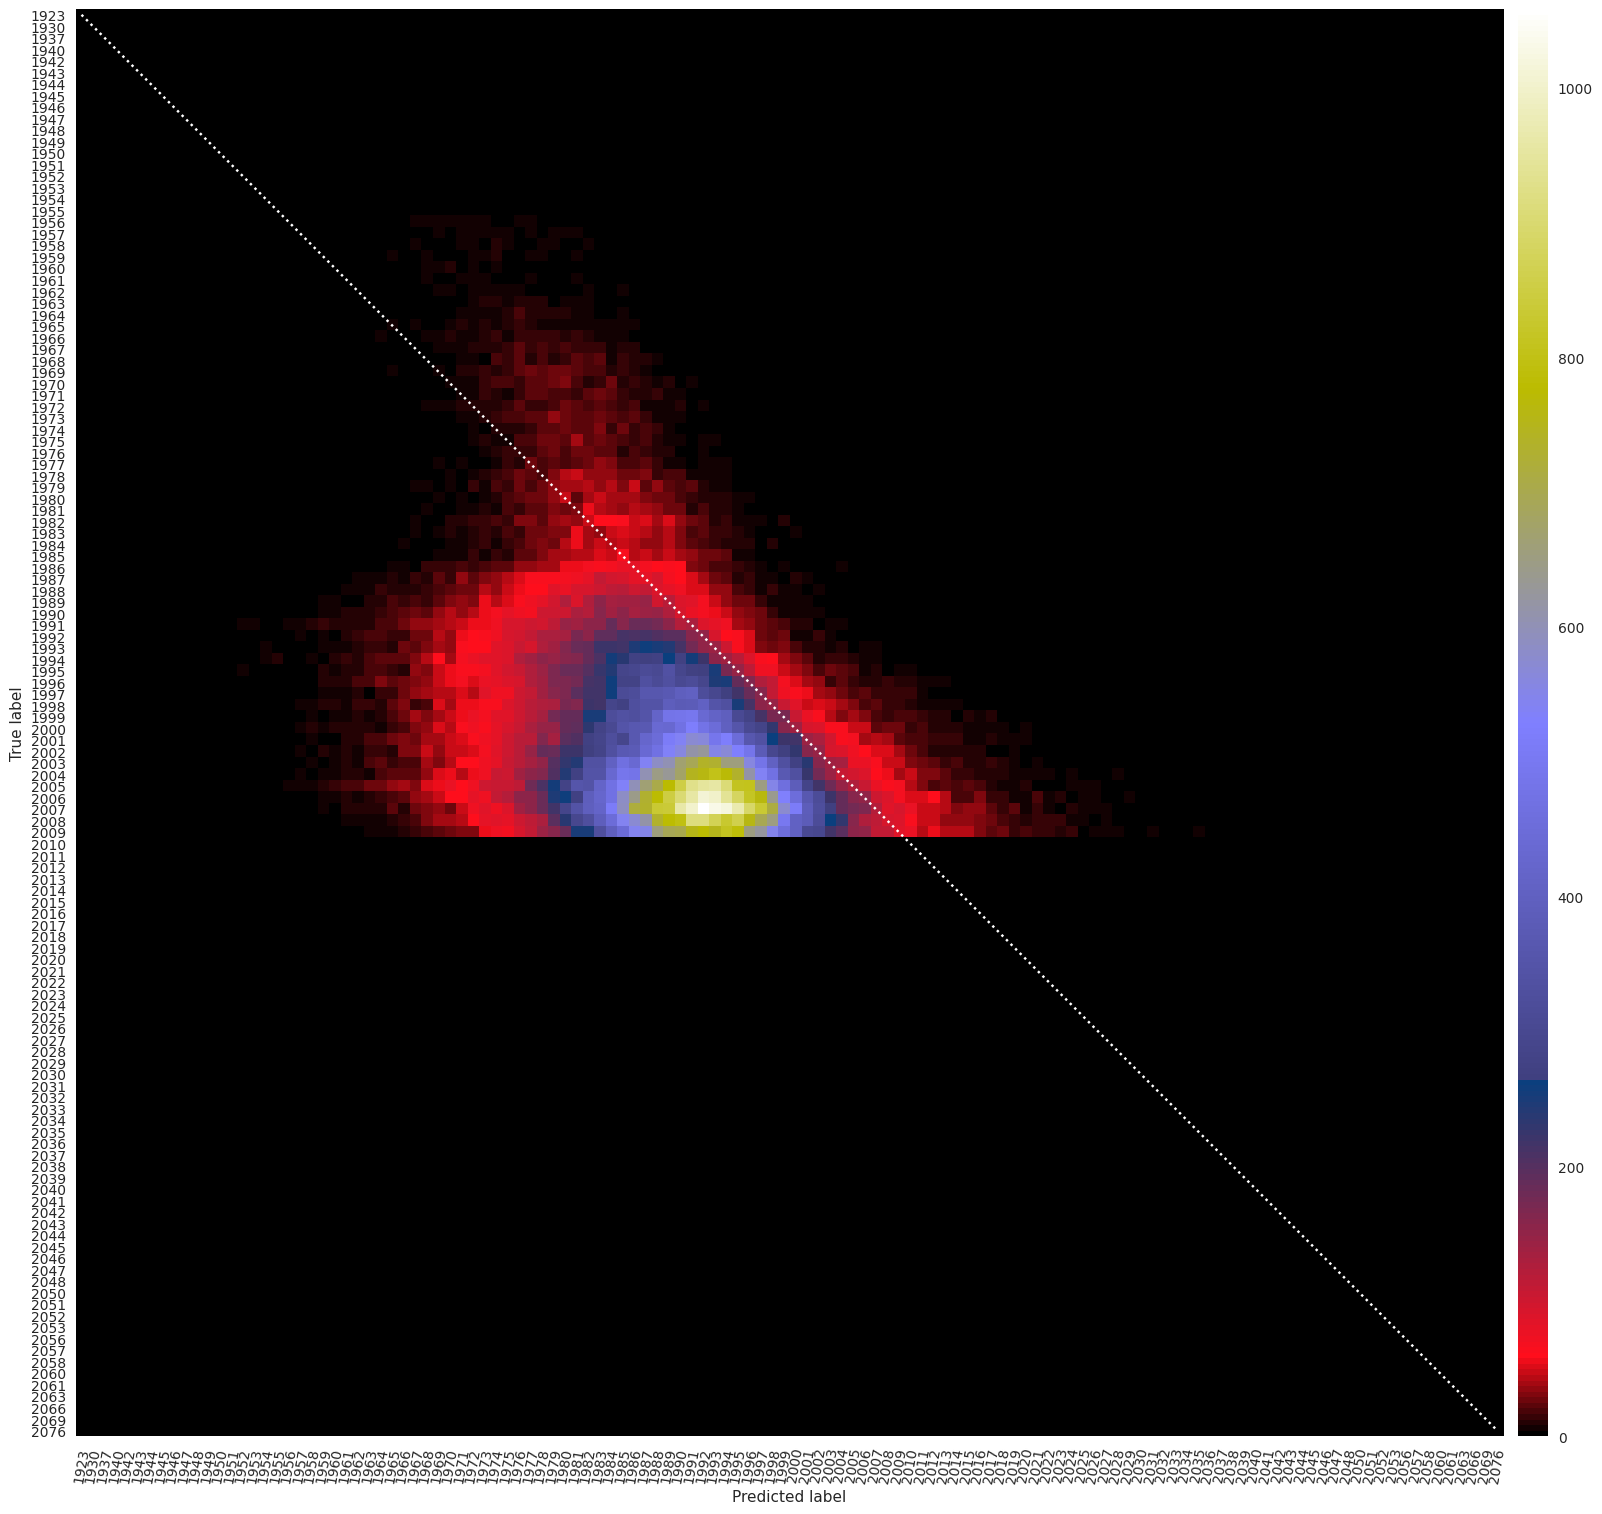

In [93]:
print_store_results(searches, predictions, "lr")

---
## RandomForestRegressor
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- LDA gives better results than PCA with even less components (53). 
- LDA gives better results with l-max-Normalization + MinMax instead of MinMax, StandardScaling, MinMax+StandardScaling.
- The following results are with a preprocess of MinMax + l-max-Normalization + LDA:
    - Keeping the number of trees to 200 with samples percentage per tree of 10% (for computational reasons):
        - The best covariance estimators are EllipticEnvelope (MinCovDet) and OAS, over EmpiricalCovariance and no-shrinkage: R^2=0.3033, MSE=76.77
        - The best "contamination" amount for EllipticEnvelope is 0.001, over 0.2, 0.1, 0.05, 0.0001, but the difference is minimal
        - The only difference is that the OAS covariance estimator takes much less time to compute instead of EllipticEnvelope
    - Incrementing the number of trees (500) and reducing the percentage of samples per tree (2.5%) (for computational reasons), the results were a bit worse but very similar
    - Decrementing the number of trees (5) with samples percentage per tree of 100%, the results were far worse (R^2=0.16, MSE=92)
- Therefore the best combination is:
    - MinMax preprocess + l-max-Normalization + LDA preprocess with OAS covariance estimator and "eigen" as solver
    - RandomForest with 200 estimators and 100% of sample per estimator: R^2=0.3195, MSE=74.98
    - There is a very big downside with this configuration: it is more than 2GB of model size, in comparison with the 328MB of the same model but with 0.1% of samples per tree (the results are the one above).

In [94]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "rf__max_samples": [0.1],
    "rf__criterion": ["squared_error"],
    "rf__n_estimators": [200],
}

searches, predictions = gridSearch("rf", RandomForestRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END lda__covariance_estimator=OAS(), lda__shrinkage=None, lda__solver=eigen, rf__criterion=squared_error, rf__max_samples=0.1, rf__n_estimators=200;, score=0.508 total time=   9.4s
[CV 1/3] END lda__covariance_estimator=OAS(), lda__shrinkage=None, lda__solver=eigen, rf__criterion=squared_error, rf__max_samples=0.1, rf__n_estimators=200;, score=0.434 total time=   9.5s
[CV 3/3] END lda__covariance_estimator=OAS(), lda__shrinkage=None, lda__solver=eigen, rf__criterion=squared_error, rf__max_samples=0.1, rf__n_estimators=200;, score=0.527 total time=   9.5s
----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.1, 'rf__n_estimators': 200}. R^2: -1.8190257306467088. MSE: 183.20394507984523


----> min-max + lmax + lda2 data. Params: {'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen', 'rf__criterion': 'squared_error', 'rf__max_samples': 0.1, 'rf__n_estimators': 200}. R^2: -1.8190257306467088. MSE: 183.20394507984523
		min-max + lmax + lda2: number of components=53, total variance=1.2747311201220386

SAVED: ----> min-max + lmax + lda2 data. R^2: -1.8190257306467088


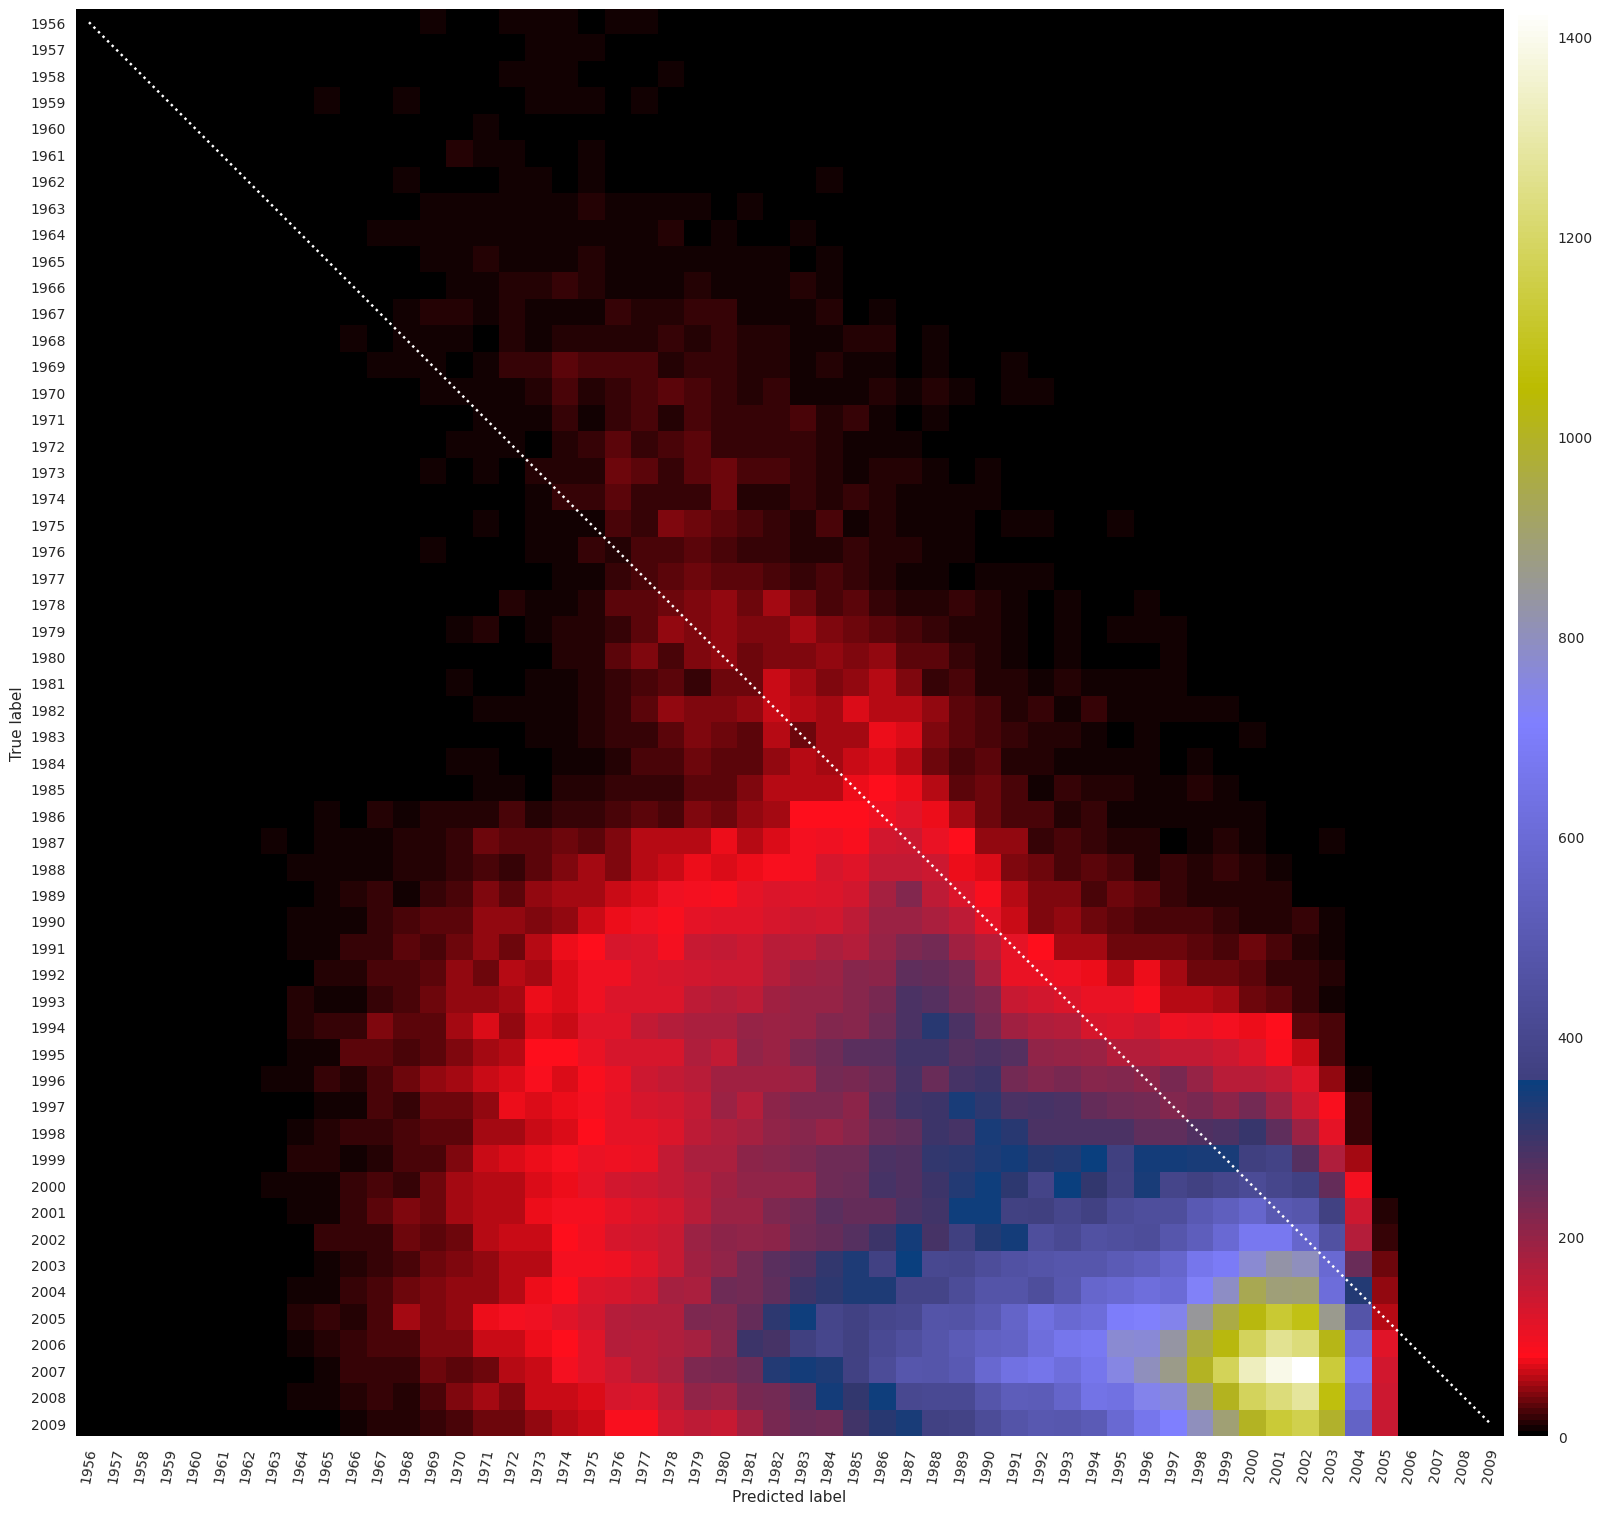

In [95]:
print_store_results(searches, predictions, "rf")

---
## KNN
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- The following search was not exhaustive: we not try all the possible combinations, but we followed the more promising paths
- The best result is R^2=0.3224 , MSE=74.66 with:
    - MinMax + l-max-Normalization + LDA. It performed better than PCA (and its combinations with preprocessing techniques), l-1-Normalization + LDA, l-2-Normalization + LDA, MinMax + l-1-Normalization + LDA, MinMax + l-2-Normalization + LDA
    - Best covariance estimator for LDA is OAS, over EllipticEnvelope, EmpiricalCovariance and no-shrinkage
    - Best KNN metric is cosine, over cityblock, euclidean, nan_euclidean, with "weights"="distance" over "uniform"
    - Best number of neighbors is 20 (tried in this order 5,30,25,20,15,17,18,19)

In [75]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "knr__n_neighbors": [20],
    "knr__weights": ["distance"],  # "uniform"
    "knr__metric": [
        # "cityblock",
        "cosine",
        # "euclidean",
        # "nan_euclidean",
    ],
}

searches, predictions = gridSearch("knr", KNeighborsRegressor(n_jobs=-1), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

----> min-max + lmax + lda2 data. Params: {'knr__metric': 'cosine', 'knr__n_neighbors': 20, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}. R^2: -0.3142272075070418. MSE: 89.55456973828126
		min-max + lmax + lda2: number of components=53, total variance=1.2178174241107333

SAVED: ----> min-max + lmax + lda2 data. R^2: -0.3142272075070418


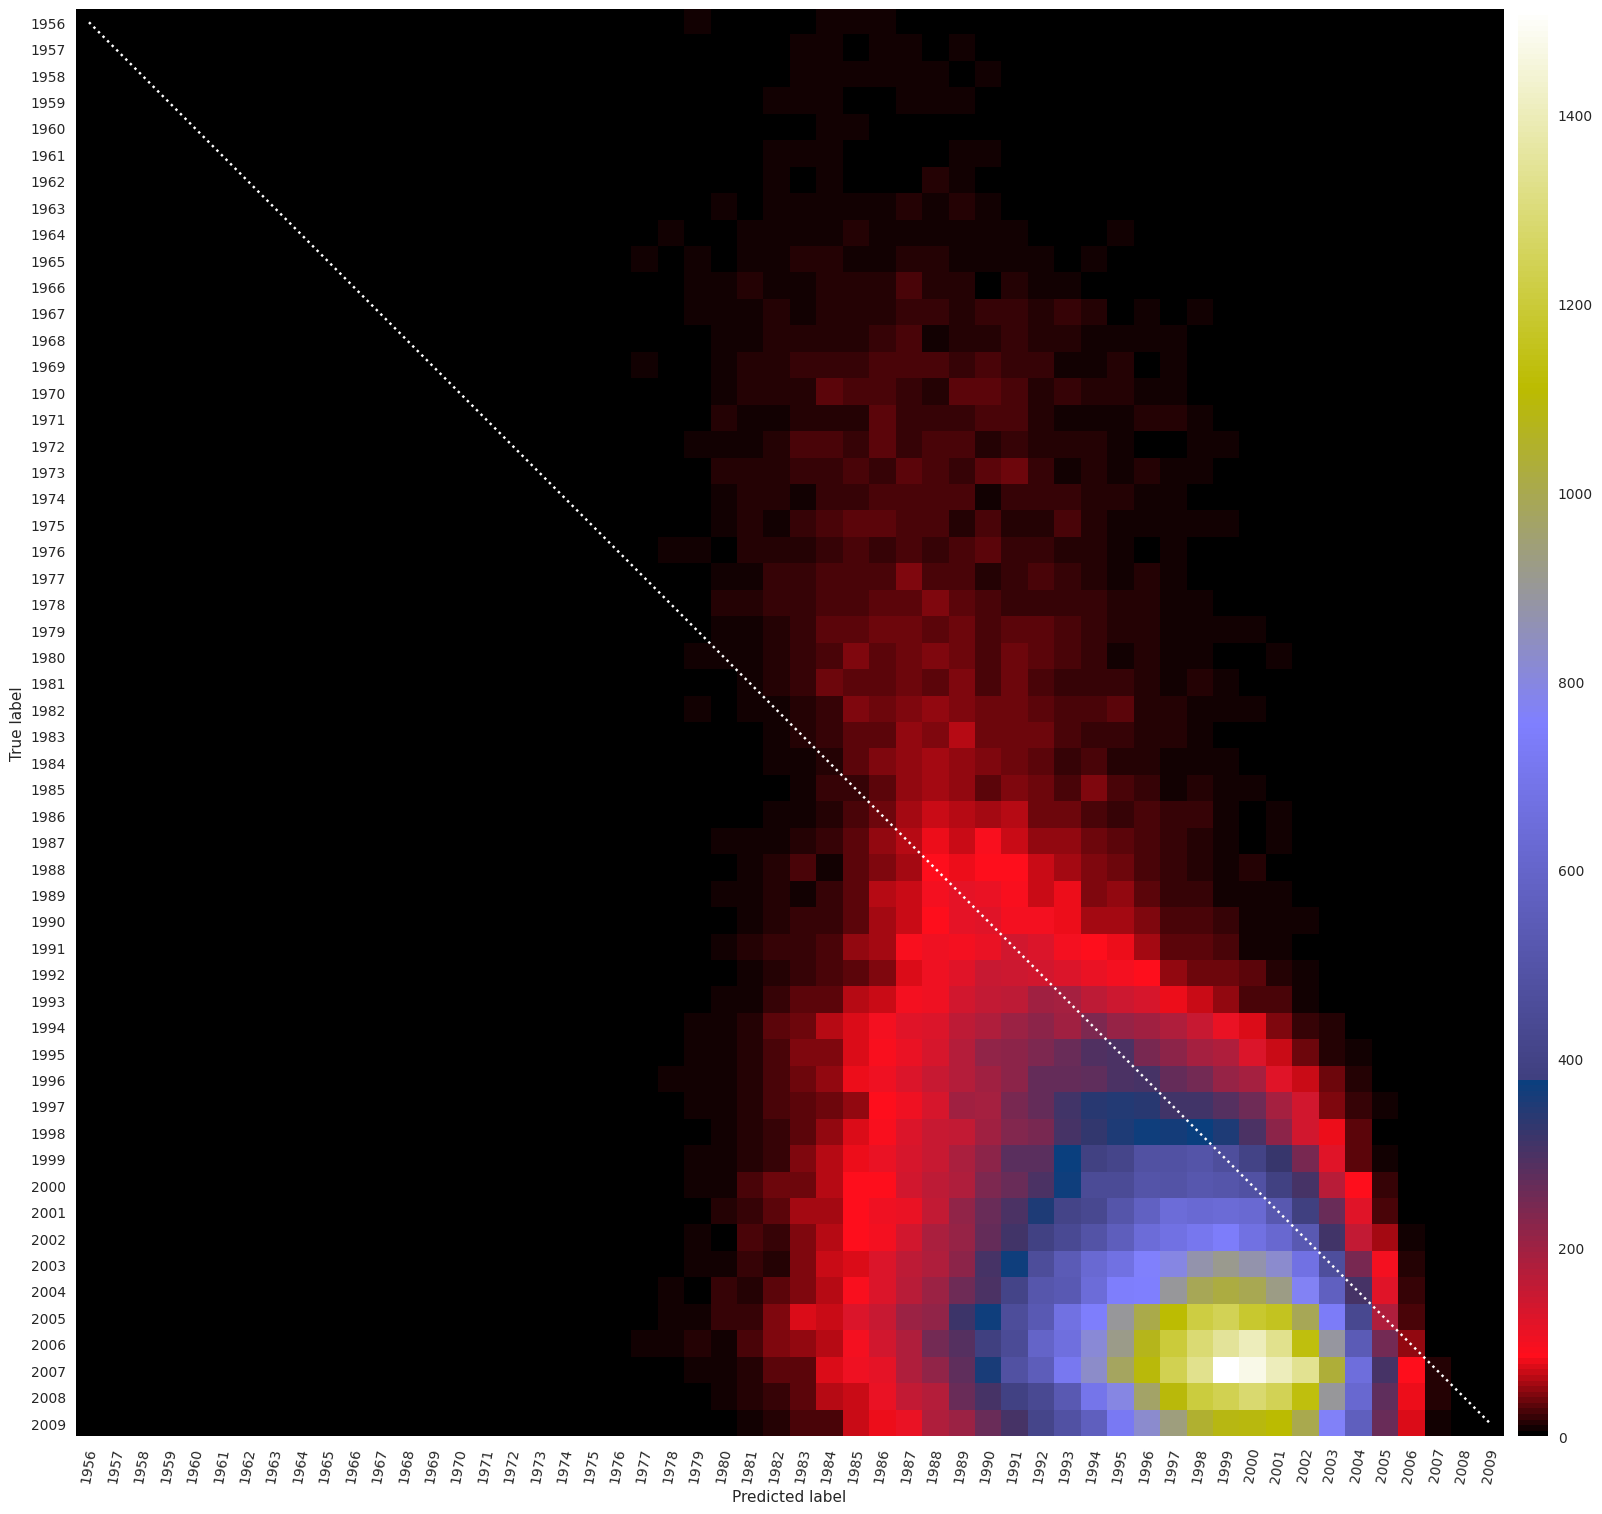

In [ ]:
print_store_results(searches, predictions, "knr")

---
## SVM

In [10]:
cv = StratifiedKFold(n_splits=3)

param_estimator = {
    "svr__epsilon": [0.01],
    "svr__C": [10],  # 0.1, 1, 100, 500, 5, 20, 8, 9,15
    # "svr__fit_intercept": [True, False],
    "svr__max_iter": [2000],
    # "svr__intercept_scaling": [1, 2]
}

searches, predictions = gridSearch("svr", LinearSVR(dual="auto", random_state=random_state), param_estimator, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


: 

----> min-max + lda + nystroem data. Params: {'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.01, 'nys__n_components': 1000, 'svr__C': 10, 'svr__epsilon': 0.01, 'svr__max_iter': 2000}. R^2: -2.0251812084518903. MSE: 196.6016577800643

SAVED: ----> min-max + lda + nystroem data. R^2: -2.0251812084518903


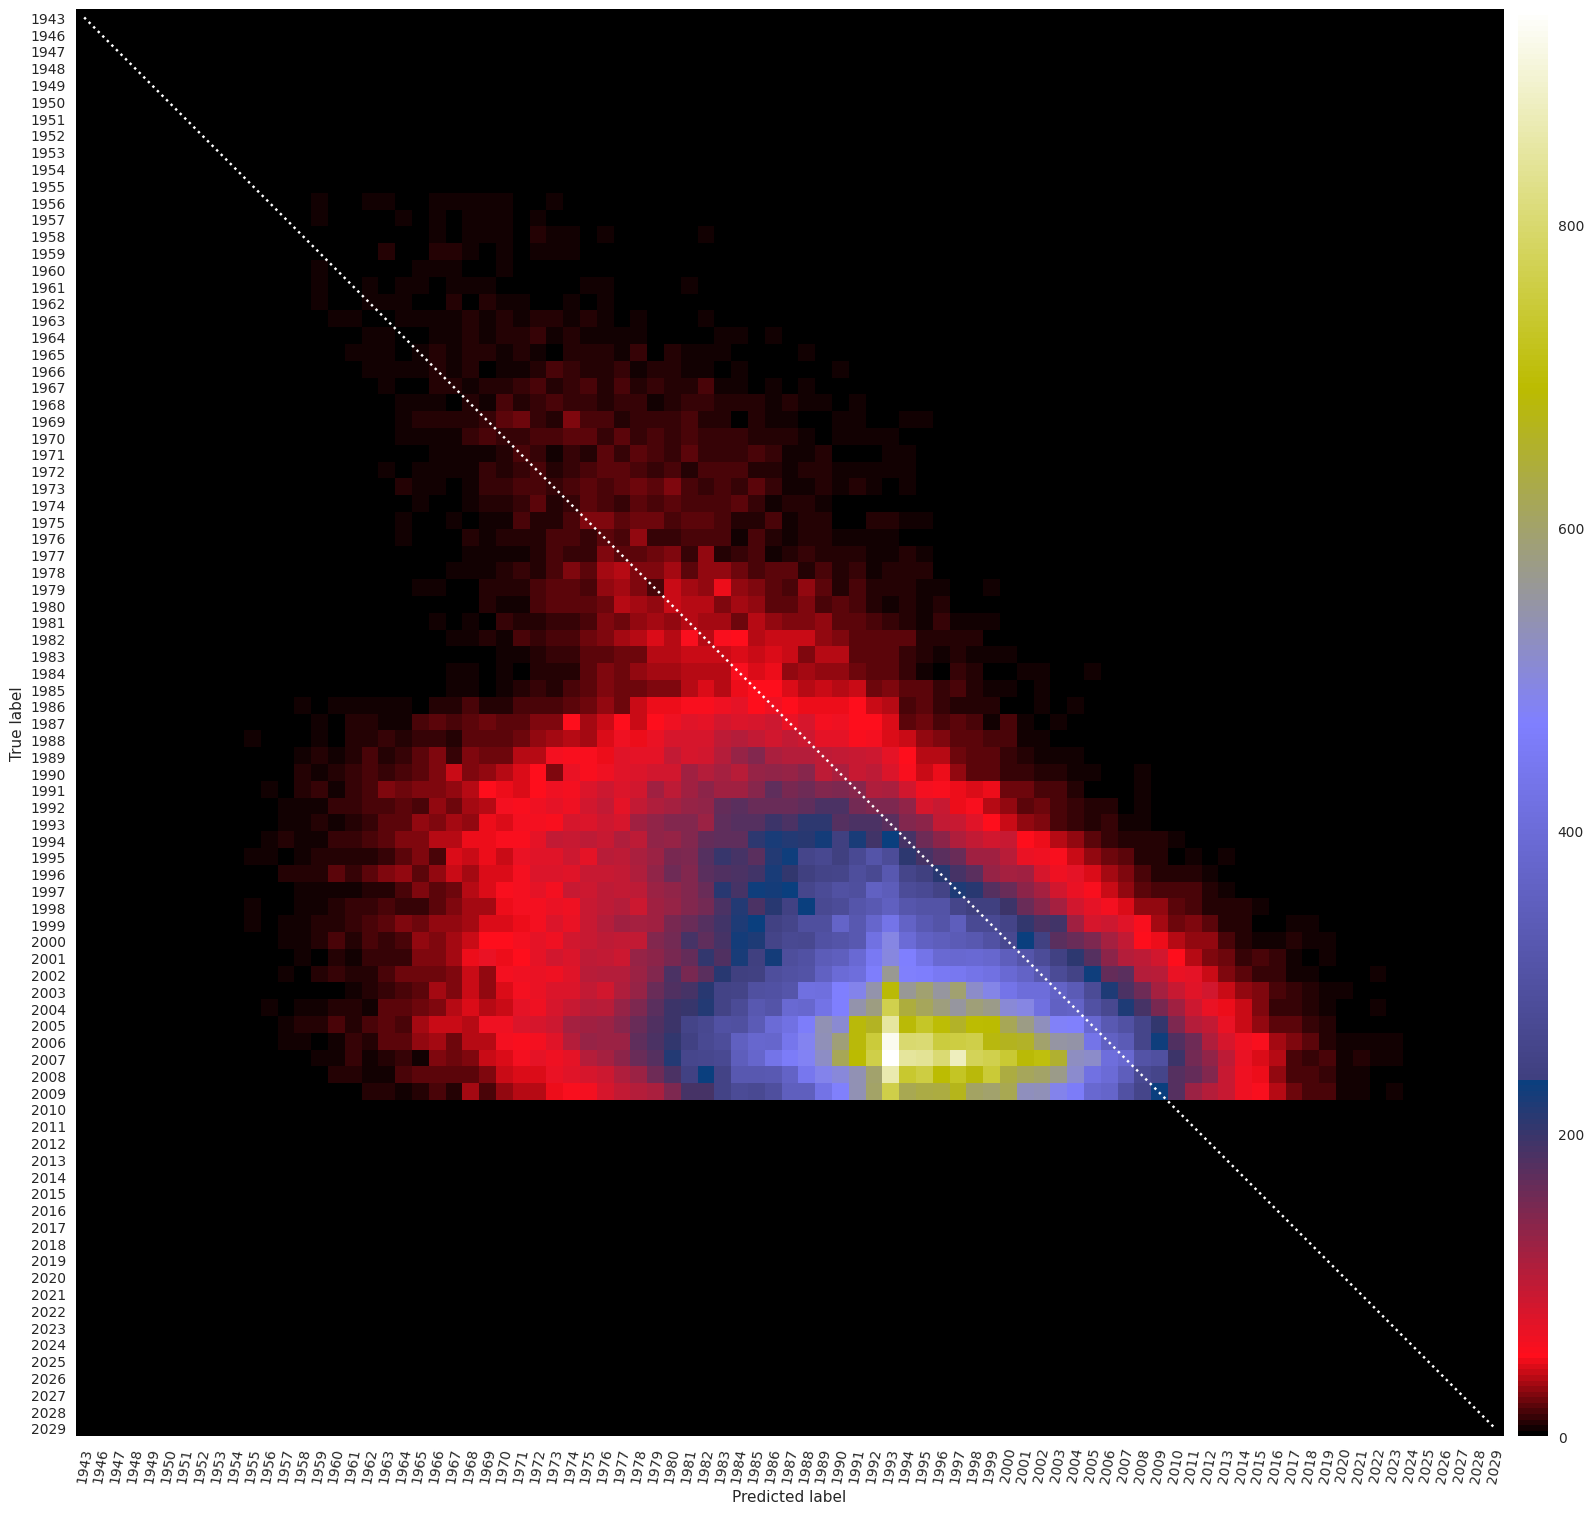

In [ ]:
print_store_results(searches, predictions, "svr")